Best epsilon: 0.00569703416354232, Best F1-Score: 0.6732673267326733


interactive(children=(FloatSlider(value=0.00569703416354232, description='threshold', max=0.01139406832708464,…

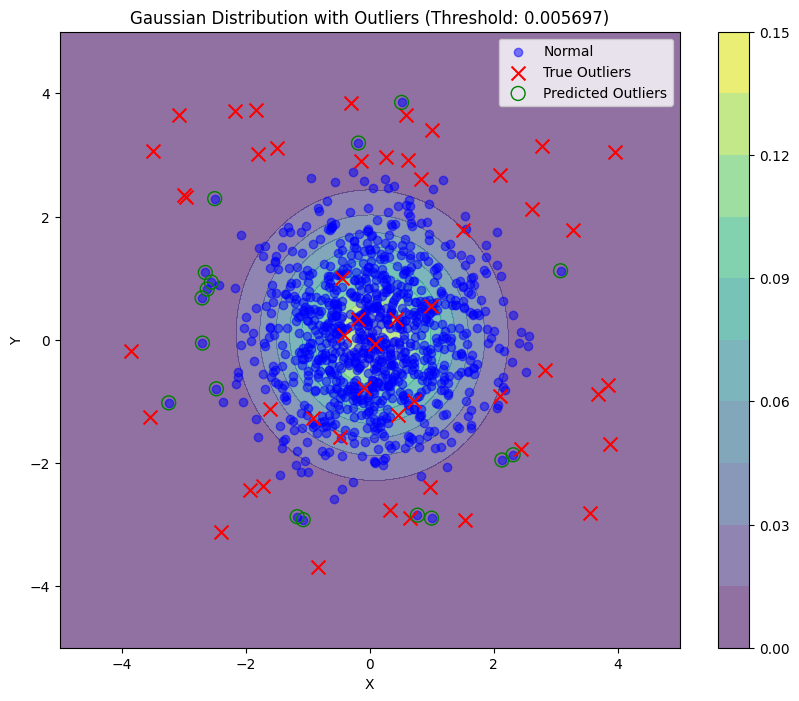

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
%matplotlib inline

def generate_data(n_samples=1000, n_outliers=50):
    np.random.seed(42)
    X = np.random.randn(n_samples - n_outliers, 2)
    outliers = np.random.uniform(low=-4, high=4, size=(n_outliers, 2))
    X = np.vstack((X, outliers))
    y = np.zeros(n_samples)
    y[-n_outliers:] = 1  # Mark outliers as 1
    return X, y


def plot_results(X, y, mu, cov, threshold):
    xx, yy = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
    X_grid = np.c_[xx.ravel(), yy.ravel()]
    
    Z = multivariate_normal_pdf(X_grid, mu, cov)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, levels=10, cmap='viridis', alpha=0.6)
    plt.colorbar()
    
    # Plot all points
    normal = y == 0
    outliers = y == 1
    plt.scatter(X[normal, 0], X[normal, 1], c='blue', alpha=0.5, label='Normal')
    plt.scatter(X[outliers, 0], X[outliers, 1], c='red', marker='x', s=100, label='True Outliers')
    
    # Identify and mark predicted outliers
    p_val = multivariate_normal_pdf(X, mu, cov)
    pred_outliers = p_val < threshold
    plt.scatter(X[pred_outliers & normal, 0], X[pred_outliers & normal, 1], 
                facecolors='none', edgecolors='green', s=100, label='Predicted Outliers')
    
    plt.title(f"Gaussian Distribution with Outliers (Threshold: {threshold:.6f})")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()


# The interesting part
def estimate_gaussian(X):
    mu = np.mean(X, axis=0)
    cov = np.cov(X.T)
    return mu, cov


def select_threshold(y_val, p_val): 
    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    step_size = (max(p_val) - min(p_val)) / 1000
    for epsilon in np.arange(min(p_val), max(p_val), step_size):
        pred = p_val < epsilon
        tp = np.sum((y_val == 1) & (pred == 1))
        fp = np.sum((y_val == 0) & (pred == 1))
        fn = np.sum((y_val == 1) & (pred == 0))
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0
        F1 = (2 * prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
    return best_epsilon, best_F1


def multivariate_normal_pdf(X, mu, cov):
    n = mu.shape[0]
    diff = X - mu
    cov_det = np.linalg.det(cov)
    cov_inv = np.linalg.inv(cov)
    norm_const = 1.0 / (np.power((2 * np.pi), n / 2) * np.sqrt(cov_det))
    result = norm_const * np.exp(-0.5 * np.sum(np.dot(diff, cov_inv) * diff, axis=1))
    return result


# Main execution
X, y = generate_data()
mu, cov = estimate_gaussian(X)

# Calculate probabilities
p_val = multivariate_normal_pdf(X, mu, cov)

# Calculate initial threshold
best_epsilon, best_F1 = select_threshold(y, p_val)
print(f"Best epsilon: {best_epsilon}, Best F1-Score: {best_F1}")

# Interactive plot with slider
@interact(threshold=FloatSlider(min=0, max=best_epsilon*2, step=best_epsilon/100, value=best_epsilon))
def update_plot(threshold):
    plot_results(X, y, mu, cov, threshold)

# Initial plot
update_plot(best_epsilon)